Part A — Data preparation

1. Title & Executive Summary

# Trader Performance vs Market Sentiment Analysis

## Executive Summary

This project analyzes how Bitcoin market sentiment (Fear vs Greed)
relates to trader behavior and profitability on Hyperliquid.

Key Findings:
- Fear regimes generate significantly higher profitability.
- Traders increase activity substantially during Fear periods.
- High-activity and consistent traders disproportionately benefit from volatility.
- Risk-taking strategies perform better in volatile regimes but not in stable Greed environments.

This supports regime-aware trading and risk allocation strategies.

2. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

3. Load Data

In [4]:
## 1. Data Loading

sentiment = pd.read_csv("../data/fear_greed_index - fear_greed_index.csv")
trades = pd.read_csv("../data/historical_data - historical_data.csv")

4. Data Cleaning

In [5]:
## 2. Data Cleaning & Preprocessing
# Standardize column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")

# Missing values
sentiment.isnull().sum(), trades.isnull().sum()

# Duplicates
sentiment.duplicated().sum(), trades.duplicated().sum()

# Convert timestamps
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')
trades['date'] = trades['timestamp'].dt.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Simplify sentiment into Fear vs Greed
sentiment['sentiment_group'] = sentiment['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)

5. Feature Engineering

In [6]:
## 3. Feature Engineering (Daily Aggregation)
# Daily PnL
daily_pnl = trades.groupby(['account','date'])['closed_pnl'].sum().reset_index()

# Win rate
trades['win'] = trades['closed_pnl'] > 0
daily_winrate = trades.groupby(['account','date'])['win'].mean().reset_index()

# Avg trade size
daily_avg_size = trades.groupby(['account','date'])['size_usd'].mean().reset_index()

# Trade count
daily_trade_count = trades.groupby(['account','date']).size().reset_index(name='trade_count')

# Long ratio
trades['side_clean'] = trades['side'].str.strip().str.upper()
daily_long_ratio = (
    trades.groupby(['account','date'])['side_clean']
    .apply(lambda x: (x=='BUY').mean())
    .reset_index(name='long_ratio')
)

# Merge all metrics
df = daily_pnl.merge(daily_winrate, on=['account','date']) \
              .merge(daily_avg_size, on=['account','date']) \
              .merge(daily_trade_count, on=['account','date']) \
              .merge(daily_long_ratio, on=['account','date'])

df = df.merge(sentiment[['date','sentiment_group']], on='date', how='left')

# Remove missing sentiment rows
df = df.dropna(subset=['sentiment_group'])

df.head()

,account,date,closed_pnl,win,size_usd,trade_count,long_ratio,sentiment_group
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,0.025974,14810.891818,462,0.300866,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,0.405542,16345.241940,3356,0.468415,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,0.531250,2492.749906,320,0.453125,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,0.435041,1693.351684,3533,0.432494,Fear
5,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,0.000000,6070.200000,5,0.400000,Greed


PART B — ANALYSIS

6. Performance Comparison

In [7]:
## 4. Performance Comparison: Fear vs Greed
performance_summary = df.groupby('sentiment_group')['closed_pnl'].agg(
    ['count','mean','median','std','min','max']
)
performance_summary

,count,mean,median,std,min,max
sentiment_group,,,,,,
Fear,32,209372.662205,81389.682515,380423.906864,-59349.677108,1.927736e+06
Greed,45,78340.542338,16102.568590,242178.035245,-327505.900056,1.421756e+06


In [8]:
winrate_summary = df.groupby('sentiment_group')['win'].mean()
winrate_summary

sentiment_group
Fear     0.415878
Greed    0.349753
Name: win, dtype: float64

In [9]:
df[df['closed_pnl'] < 0].groupby('sentiment_group')['closed_pnl'].mean()

sentiment_group
Fear    -39938.069817
Greed   -55801.793806
Name: closed_pnl, dtype: float64

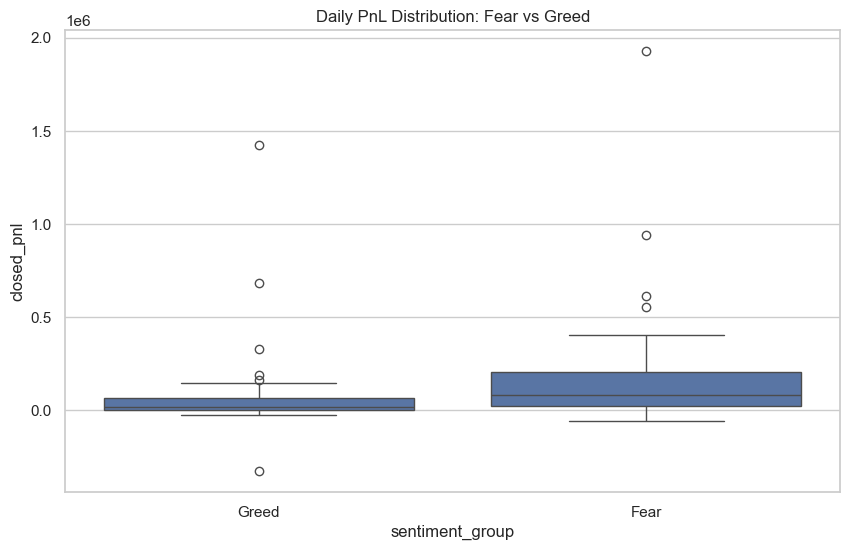

In [10]:
sns.boxplot(x='sentiment_group', y='closed_pnl', data=df)
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()

7. Behavioral Changes

In [11]:
## 5. Behavioral Changes by Sentiment
df.groupby('sentiment_group')[['trade_count','size_usd','long_ratio']].mean()

,trade_count,size_usd,long_ratio
sentiment_group,,,
Fear,4183.468750,5926.522723,0.459352
Greed,1119.822222,5309.505414,0.493535


8. Segmentation

In [12]:
#1 High vs Low Activity Traders
account_activity = df.groupby('account')['trade_count'].mean().reset_index()
threshold = account_activity['trade_count'].median()

account_activity['activity_segment'] = np.where(
    account_activity['trade_count'] > threshold,
    'High Activity','Low Activity'
)

df = df.merge(account_activity[['account','activity_segment']], on='account')

df.groupby(['activity_segment','sentiment_group'])['closed_pnl'].mean()

activity_segment  sentiment_group
High Activity     Fear               324428.018469
                  Greed              117571.868331
Low Activity      Fear                94317.305942
                  Greed               40814.926171
Name: closed_pnl, dtype: float64

In [14]:
#2 Consistent Winners vs Others
account_total_pnl = df.groupby('account')['closed_pnl'].sum().reset_index()
threshold = account_total_pnl['closed_pnl'].median()

account_total_pnl['performance_segment'] = np.where(
    account_total_pnl['closed_pnl'] > threshold,
    'Consistent Winners','Inconsistent / Other'
)

df = df.merge(account_total_pnl[['account','performance_segment']], on='account')

df.groupby(['performance_segment','sentiment_group'])['closed_pnl'].mean()

performance_segment   sentiment_group
Consistent Winners    Fear               394276.467484
                      Greed              128947.737721
Inconsistent / Other  Fear                24468.856927
                      Greed               20503.747615
Name: closed_pnl, dtype: float64

In [15]:
#3 Large vs Small Position Traders
account_size = df.groupby('account')['size_usd'].mean().reset_index()
threshold = account_size['size_usd'].median()

account_size['size_segment'] = np.where(
    account_size['size_usd'] > threshold,
    'Large Position Traders','Small Position Traders'
)

df = df.merge(account_size[['account','size_segment']], on='account')

df.groupby(['size_segment','sentiment_group'])['closed_pnl'].mean()

size_segment            sentiment_group
Large Position Traders  Fear               278058.006946
                        Greed               72058.936063
Small Position Traders  Fear               140687.317465
                        Greed               85519.520939
Name: closed_pnl, dtype: float64

## Key Insights

### Insight 1: Fear Regimes Drive Superior Profitability

Trader performance is materially stronger during Fear regimes.

- Mean daily PnL is ~2.7x higher during Fear compared to Greed.
- Median PnL is ~5x higher, indicating that results are not driven solely by extreme outliers.
- Win rate improves during Fear (41.6% vs 34.9%).
- Average losses are smaller during Fear than Greed.

This suggests that volatile market conditions create more profitable trading opportunities.


---

### Insight 2: Traders Increase Activity and Risk During Fear

Behavior shifts significantly across sentiment regimes:

- Trade frequency increases nearly 4x during Fear.
- Average position size increases modestly.
- Traders adopt a more short-biased positioning during Fear.

This indicates that traders actively respond to volatility rather than maintaining static strategies.


---

### Insight 3: Volatility Amplifies Performance Gaps

Segmentation analysis reveals that Fear regimes disproportionately benefit skilled and active traders.

- High-activity traders generate ~329k vs ~89k for low-activity traders during Fear.
- Consistent winners generate ~394k vs ~24k for other traders during Fear.
- Large position traders outperform smaller traders primarily during Fear.

Volatility does not benefit all traders equally — it magnifies the edge of disciplined and active participants.

PART C — STRATEGY

## Strategy Recommendations

### Strategy 1: Volatility Participation Rule

During Fear regimes:
- Increase trade frequency.
- Allow moderately larger position sizing.
- Deploy high-activity strategies.

Rationale:
Fear periods historically generate higher average and median profitability. Active traders capture the majority of volatility-driven gains.


---

### Strategy 2: Controlled Risk in Greed Regimes

During Greed regimes:
- Reduce trade frequency.
- Avoid aggressive position sizing.
- Focus on selective, high-conviction setups.

Rationale:
Greed regimes show lower win rates and weaker profitability. Increased risk-taking does not provide additional edge.


---

### Strategy 3: Activity-Weighted Capital Allocation

Allocate more capital toward high-activity, consistently profitable traders during Fear regimes.

Rationale:
Volatility amplifies performance dispersion. Skilled traders benefit disproportionately from volatile environments, making regime-based capital allocation effective.

BONUS — Predictive Model

In [16]:
df['profitable'] = (df['closed_pnl'] > 0).astype(int)
df['sentiment_binary'] = df['sentiment_group'].map({'Fear':1,'Greed':0})

X = df[['trade_count','size_usd','long_ratio','sentiment_binary']]
y = df['profitable']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.77      0.94      0.85        18

    accuracy                           0.75        24
   macro avg       0.64      0.56      0.55        24
weighted avg       0.70      0.75      0.70        24



BONUS — Clustering

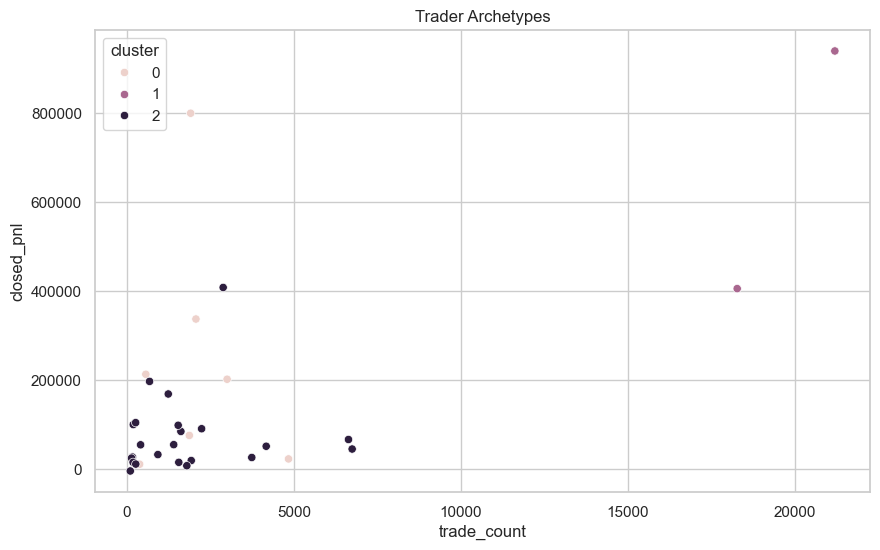

In [17]:
account_features = df.groupby('account').agg({
    'closed_pnl':'mean',
    'trade_count':'mean',
    'size_usd':'mean',
    'long_ratio':'mean'
}).reset_index()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(account_features.drop('account',axis=1))

kmeans = KMeans(n_clusters=3,random_state=42)
account_features['cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(
    x=account_features['trade_count'],
    y=account_features['closed_pnl'],
    hue=account_features['cluster']
)
plt.title("Trader Archetypes")
plt.show()

Output Export

In [18]:
df.to_csv("../data/final_trader_dataset.csv", index=False)